# Explanation
## I merged two famous hash function:
## * Bernstein hash (called djb2)
## * CBU hash from the CanterBury University, New Zeland

### The idea is start the hash with a prime number 5953. It was mabe by sum the birthday years of Simone (1957... wrote badly but the number was already prime), Anna 1999 and Luca 1997.

### For the shift and sum i use another "luky" numbers different from the Bernstein's "luky" number (33). 

### The ordinal of a character is really small, for this i want to mutiplicate it by 7 (the number of perfection) in the following way: shift of 3 and sub the number: $7=2^3-1$.

### By an analysis of the file passwords1.txt and by the formula [1] at the [Ackermoon](https://hackernoon.com/probabilistic-data-structures-bloom-filter-5374112a7832) we choose a binary vector of length $4294967296$ and 10 hash function.

### We choose a number of around $4000000000$ bits is because it is big enough to be saved and load in a few minutes in case of erros; 
### the number $4294967296$ it's to optimize the modulo operation at the end of the hash function; A modulo of number by a power of two can be compute with only a left shift of the exponent of the two

### 10 hash functions it's to decrese the probability to obtain a false positive

### the probability to obtain a false positive, by the formula is $1.4949314800622724 e^{-7}$

### As you can se following, the hash function is uniformally distributed:

12.220977067947388
800000


(array([78821., 81222., 78854., 80959., 79655., 79760., 80919., 79694.,
        79797., 80319.]),
 array([3.78300000e+04, 4.29528816e+08, 8.59019801e+08, 1.28851079e+09,
        1.71800177e+09, 2.14749276e+09, 2.57698374e+09, 3.00647473e+09,
        3.43596571e+09, 3.86545670e+09, 4.29494769e+09]),
 <a list of 10 Patch objects>)

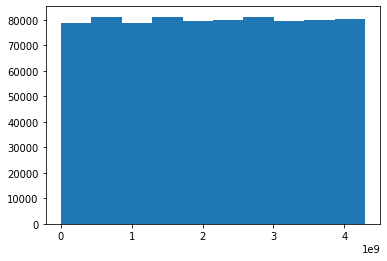

In [4]:
import matplotlib.pyplot as pp
import numpy as np
import time
import multiprocessing as mp

def TiagoHashFunctionProva(s, SIZE, prime):
    hash=5953
    for i in range(len(s)):
        hash=((hash<<prime)+hash)*((ord(s[i])<<3))-ord(s[i])#it's uniformuly distribuited
    return abs(hash) & (SIZE-1) #because the size it's a power of 2, we can compute the modulo by an bitwise AND; effecenze encrese

SIZE=4294967296
lukyNumber=[17, 31, 63, 127, 129, 137, 151, 163, 181, 197]
start=time.time()
i=0
l=[]
with open('./DATA/passwords2.txt', 'r') as f:
    for password in f:
        i+=1
        if i>80000:
            break
        result=[TiagoHashFunctionProva(password, SIZE, p) for p in lukyNumber]#, 129, 137, 151, 163, 181, 197
        l+=result
print(time.time()-start)
print(len(l))
pp.hist(l)

In [ ]:
import matplotlib.pyplot as pp
import numpy as np
import time
import sys
#SIZE=17179869183
myBloomFilter=BloomFilter()#Create a new bloom filter
start=time.time()
print('start insert')
s1=time.time()
with open('./DATA/passwords1.txt', 'r') as f:
    for password in f:
        myBloomFilter.insert(password.strip('\n'))#population of the filter
            
myBloomFilter.save('./DATA/bloomFilter')#save the filter into a file fore security
dup=0
print('start check')
with open('./DATA/passwords2.txt', 'r') as f: 
    with open('./DATA/duplicates.txt', 'w') as duplicates:
        for password in f:
            check=myBloomFilter.check(password.strip('\n'))#checking
            if check:
                duplicates.write(password+'\n')#save a 'possibilty duplicate' into a file
                dup+=1
end=time.time()


print('Number of hash function used: ', myBloomFilter.get_hash_number())
print('Number of duplicates detected: ', dup)
print('Probability of false positives: ', myBloomFilter.get_probability_false_positive())
print('Execution time: ', end-start)

In [1]:
import numpy as np
import math
import multiprocessing as mp
class BloomFilter:
    
    def __init__(self, m=4294967296):#for me it's the maximum length for a numpy array
                                        # if you change this number be sure that's a power of 2; 
                                        #it's important by the 
        print('Start to create the filter..')
        self.SIZE=m
        self.num_proc=10 #number of thread for paralleling processing
        self.filter=np.zeros((self.SIZE), dtype=bool)#the filter
        self.lukyNumbers=[17, 31, 63, 127, 129, 137, 151, 163, 181, 197]#the set to build 4 different hash function made from the hash function inside the class
        print('Filter created succesfully!')
        
    def __str__(self):
        return 'Dimension of the filter: {}'.format(self.SIZE)
    
    def hashFunction(self, s, SIZE, prime):#the hash function of the filter
        hash=5953
        for i in range(len(s)):
            hash=((hash<<prime)+hash)*((ord(s[i])<<3))-ord(s[i])#it's uniformuly distribuited
        return abs(hash) & (SIZE-1) #because the size it's a power of 2, we can compute the modulo by an bitwise AND; efficenty encrease
        
    def insert(self, s):#insert the string s in the filter
        for p in self.lukyNumbers:#iterate over the number to differentiate the hash functions
            key=self.hashFunction(s, self.SIZE, p) #calculate the hash
            self.filter[key]=True#and set the filter
            
    def check(self, password):#check if a string is definitely in the filter or maybe not in the filter           
        bits=[self.filter[self.hashFunction(password, self.SIZE, n)] for n in self.lukyNumbers]#obtain the bit of the filter
        collision=True
        for bit in bits:#scan the bits
            if bit==False:# if we found a False bit
                collision=False#we can conlude the password is defintely not in the filter
                break#break the loop for efficenty
        return collision
    
    def load(self, file):#load an existing numpy array filter; file must ends with .npy
        print('Loading {} file...'.format(file))
        self.filter=np.load(file)#load
        self.m=len(self.filter)#and set the dimension
        print('Loading complete succesfully!')
        
    def save(self, path_to_file):#save the filter into a numpy file 
        print('Saving into {} file..'.format(path_to_file))
        np.save(path_to_file, self.filter)#save
        print('Saving complete succesfully!')
        
    def get_filter(self):#return the filter inside
        return self.filter
    
    def get_hash_number(self): #return the number of the hash functions used
        return len(self.lukyNumbers)
    
    def get_probability_false_positive(self):#return the probility of a false positive
        k=len(self.lukyNumbers)
        n=100000000
        return (1-math.exp(1)**((-k*n)/self.SIZE))**k